CODE BLOCK: 1

In [13]:
# Import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [4]:
# Fetch MNIST dataset
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [5]:
# Data loader for train and test sets
batch_size = 256

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}
kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 0, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

In [6]:
# Sample input size with batch
next(iter(train_loader))[0].shape

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([256, 1, 28, 28])

CODE BLOCK: 6

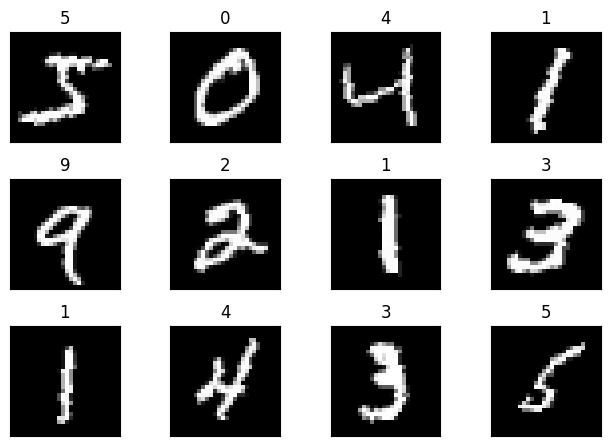

In [7]:
# Sample train images
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [10]:
# # First model
# class Net(nn.Module):
#     # Structure of the NN
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5)  # 8x24x24
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 8x12x12
#         self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)  # 16x8x8
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 16x4x4
#         self.fc1 = nn.Linear(in_features=16*4*4, out_features=64)  # 64
#         self.fc2 = nn.Linear(in_features=64, out_features=10)  # 10

#     # Feed forward of the NN
#     def forward(self, x):
#         x = self.pool1(F.relu(self.conv1(x)))
#         x = self.pool2(F.relu(self.conv2(x)))
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = F.log_softmax(self.fc2(x), dim=1)
#         return x

# # No of model parameters
# model = Net()
# print('Total parameters:', sum([p.numel() for p in model.parameters()]))
# print('Trainable parameters:', sum([p.numel() for p in model.parameters() if p.requires_grad]))

In [22]:
# Final model
class Net(nn.Module):
    # Structure of the NN
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3)
        self.fc1 = nn.Linear(in_features=24*4*4, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    # Feed forward of the NN
    def forward(self, x):
        x = F.relu(self.conv1(x))  # 8x26x26
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 8x13x13
        x = F.relu(self.conv2(x))  # 16x11x11
        x = F.relu(self.conv3(x))  # 24x9x9
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 24x4x4
        x = x.view(x.size(0), -1)  # 384
        x = F.relu(self.fc1(x))  # 50
        x = F.log_softmax(self.fc2(x), dim=1)  # 10
        return x

In [23]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2           [-1, 16, 11, 11]           1,168
            Conv2d-3             [-1, 24, 9, 9]           3,480
            Linear-4                   [-1, 50]          19,250
            Linear-5                   [-1, 10]             510
Total params: 24,488
Trainable params: 24,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.09
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


CODE BLOCK: 8

In [18]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [19]:
# Train and test workflows

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()

            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [25]:
# Model training and inference
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

criterion = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.2144 Batch_id=234 Accuracy=91.21: 100%|██████████| 235/235 [00:41<00:00,  5.60it/s]


Test set: Average loss: 0.0003, Accuracy: 9801/10000 (98.01%)

Epoch 2


Train: Loss=0.1791 Batch_id=234 Accuracy=97.13: 100%|██████████| 235/235 [00:35<00:00,  6.60it/s]


Test set: Average loss: 0.0002, Accuracy: 9815/10000 (98.15%)

Epoch 3


Train: Loss=0.1749 Batch_id=234 Accuracy=97.74: 100%|██████████| 235/235 [00:35<00:00,  6.60it/s]


Test set: Average loss: 0.0002, Accuracy: 9857/10000 (98.57%)

Epoch 4


Train: Loss=0.2027 Batch_id=234 Accuracy=98.03: 100%|██████████| 235/235 [00:35<00:00,  6.64it/s]


Test set: Average loss: 0.0002, Accuracy: 9877/10000 (98.77%)

Epoch 5


Train: Loss=0.1338 Batch_id=234 Accuracy=98.09: 100%|██████████| 235/235 [00:35<00:00,  6.68it/s]


Test set: Average loss: 0.0001, Accuracy: 9877/10000 (98.77%)

Epoch 6


Train: Loss=0.1125 Batch_id=234 Accuracy=98.76: 100%|██████████| 235/235 [00:35<00:00,  6.58it/s]


Test set: Average loss: 0.0001, Accuracy: 9908/10000 (99.08%)

Epoch 7


Train: Loss=0.1361 Batch_id=234 Accuracy=98.92: 100%|██████████| 235/235 [00:35<00:00,  6.55it/s]


Test set: Average loss: 0.0001, Accuracy: 9914/10000 (99.14%)

Epoch 8


Train: Loss=0.1332 Batch_id=234 Accuracy=98.97: 100%|██████████| 235/235 [00:35<00:00,  6.57it/s]


Test set: Average loss: 0.0001, Accuracy: 9910/10000 (99.10%)

Epoch 9


Train: Loss=0.1582 Batch_id=234 Accuracy=99.02: 100%|██████████| 235/235 [00:36<00:00,  6.51it/s]


Test set: Average loss: 0.0001, Accuracy: 9926/10000 (99.26%)

Epoch 10


Train: Loss=0.1574 Batch_id=234 Accuracy=99.07: 100%|██████████| 235/235 [00:35<00:00,  6.54it/s]


Test set: Average loss: 0.0001, Accuracy: 9913/10000 (99.13%)



CODE BLOCK: 11

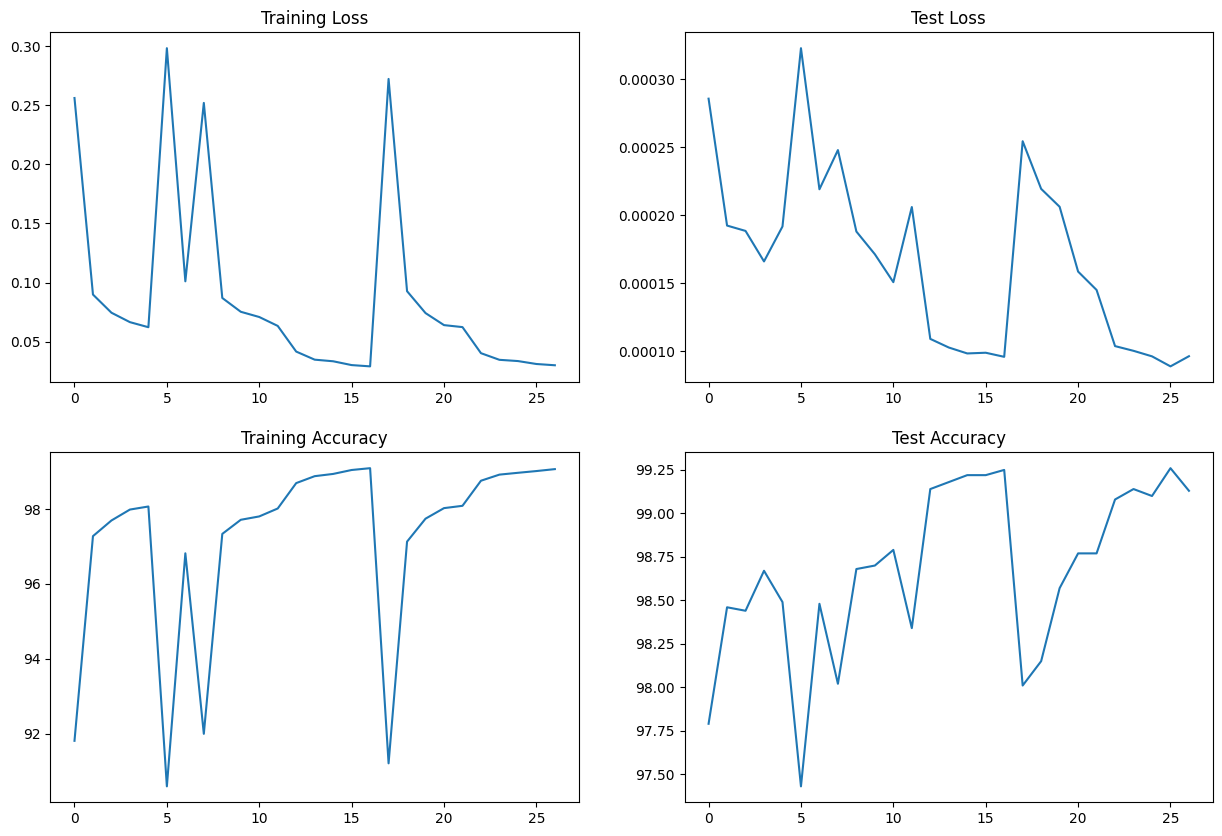

In [26]:
# Accuracy and loss plots
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy");